In [252]:
# Parameters
scale = 10               # domain size mulitplier
reynoldsNumber = 7500
TRT = True              # Enable two relaxation time (False == BGK/SRT)
aspectRatio = 1         # NY/NX ratio
relaxationCoeff = 1     # Under-relaxation coefficient.  Keep at 1 to disable, or below 1 to mitigate oscillations
nMsg = 500 * scale ** 2 # status update frequency

# Constants
nThreads = 32         # GPU threads
nX = nThreads * scale
nY = aspectRatio * nX
uMax = 0.1
nu = uMax * nX / reynoldsNumber
tau = nu * 3 + 0.5
cs = 1.0 / (3.0 ** 0.5)
mach = uMax / cs
omega = 1.0 / tau
q = 9
w0 = 4.0 / 9.0
ws = 1.0 / 9.0
wd = 1.0 / 36.0
nSteps = 1.0E8
rho0 = 1.0
threshold = 1.0E-15  # Convergence threshold
df0 = 1.0
rhobar = 1.0
magic = 0.25;
omegaMinus  = 1.0 / (0.5 + (magic / ((1.0 / omega) - 0.5)));

oclOptions=['-cl-no-signed-zeros','-cl-strict-aliasing', '-cl-mad-enable']

# Memory Calculations
bytesPerMB = 1000.0 ** 2
bytesPerGB = 1000.0 ** 3

# Print Simulation Information
print("Simulating 2D Lid-driven cavity")
print("      domain size: %u x %u" % (nX, nY))
print("               nu: %g"      % nu)
print("              tau: %g"      % tau)
print("            u_max: %g"      % uMax)
print("             Mach: %g"      % (mach))
print("    message every: %u steps" % nMsg)

Simulating 2D Lid-driven cavity
      domain size: 320 x 320
               nu: 0.00426667
              tau: 0.5128
            u_max: 0.1
             Mach: 0.173205
    message every: 50000 steps


In [253]:
from __future__ import absolute_import, print_function
import numpy as np
import pyopencl as cl
from pyopencl import array as gpuarray
from pyopencl.reduction import ReductionKernel
from time import time

nX = int(nX)
nY = int(nY)
nXnY = nX * nY

# Spitting domain on GPU
localWorkSize = (nThreads, 1, 1)  # block size
globalWorkSize = (scale, nY, 1)   # grid size

# Intialize cl and print information
platformIndex = 0 # Assuming platform #0
deviceIndex = 0   # Assuming device #0
platform = cl.get_platforms()[platformIndex]
device = platform.get_devices()[deviceIndex]
deviceInfo = cl.device_info
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

# get GPU property
def gpuProperty(propertyName):
    return device.get_info(getattr(deviceInfo, propertyName))

print("OpenCL information:")
print("      using platform: %d"        % platformIndex)
print("        using device: %d"        % deviceIndex)
print("                name: %s %s"     % (platform.name, device.name))
print("             version: %s"        % (gpuProperty("VERSION")))
print("           C version: %s"        % (gpuProperty("OPENCL_C_VERSION")))
print("  compute capability: %d.%d"     % (gpuProperty("COMPUTE_CAPABILITY_MAJOR_NV"),gpuProperty("COMPUTE_CAPABILITY_MINOR_NV")))
print("       compute units: %d"        % gpuProperty("MAX_COMPUTE_UNITS"))
print("       global memory: %.1f GB"   % (gpuProperty("GLOBAL_MEM_SIZE") / (bytesPerGB)))

# Allocate memory
doubleType = cl.cltypes.double
f0GPU   = gpuarray.zeros(queue, nXnY,        doubleType)
f1GPU   = gpuarray.zeros(queue, nXnY * q,    doubleType)
f2GPU   = gpuarray.zeros(queue, nXnY * q,    doubleType)
rhoGPU  = gpuarray.zeros(queue, nXnY,        doubleType).fill(1)
uGPU    = gpuarray.zeros(queue, nXnY,        doubleType)
vGPU    = gpuarray.zeros(queue, nXnY,        doubleType)

sizeOfDouble = f0GPU.nbytes / (f0GPU.size)
memorySizeDistribution0 = sizeOfDouble * nXnY
memorySizeDistributionN0 = sizeOfDouble * nXnY * (q - 1)
memorySizeScalar = sizeOfDouble * nXnY
memorySizeProps = 7 * scale * nY * sizeOfDouble
totalMemoryBytes = memorySizeDistribution0 + 2 * memorySizeDistributionN0 + 3 * memorySizeScalar + memorySizeProps

print('\nSize of Double:\t\t%d Bytes' % (sizeOfDouble))
print('Total Memory Usage:\t%.2e MB' % (totalMemoryBytes/bytesPerMB))

OpenCL information:
      using platform: 0
        using device: 0
                name: NVIDIA CUDA GeForce GTX 970
             version: OpenCL 1.2 CUDA
           C version: OpenCL C 1.2 
  compute capability: 5.2
       compute units: 13
       global memory: 4.2 GB

Size of Double:		8 Bytes
Total Memory Usage:	1.66e+01 MB


In [254]:
# Function Definitions

definew0 = """const double w0 = 4.0 / 9.0;"""
definews = """const double ws = 1.0 / 9.0;"""
definewd = """const double wd = 1.0 / 36.0;"""

# Index function for nX x nY domain
gpuField0Index = """
size_t gpu_field0_index(const unsigned int x, const unsigned int y)
{{
    return {nX:d} * y + x;
}}
""".format(nX=nX)

# Index function for nX x nY x Q domain
gpuFieldNIndex = """
size_t gpu_fieldn_index(const unsigned int x, const unsigned int y, const unsigned int d)
{{
    return ({nX:d} * ( {nY:d} * (d - 1) + y) + x);
}}
""".format(nX=nX, nY=nY)

# Compute equilibrium distribution
gpuSingleFeq = """
double gpu_single_feq(const double wrho, const double cdotu, const double u2x15)
{
    return wrho * (1.0 + (3.0 * cdotu) + (4.5 * (cdotu * cdotu) - u2x15));
}
"""

# Initial condition equilibrium distribtion
gpuInitEquilibriumKernel = gpuSingleFeq + gpuField0Index + gpuFieldNIndex + """
    __kernel void function(__global double *f0, __global double *f1, __global const double *r, __global const double *u, __global const double *v)
    {
    
   """ + definew0 + definews + definewd +  """
    const unsigned int y = get_group_id(1); // blockIdx.y;
    const unsigned int x = get_global_id(0);   // blockIdx.x * blockDim.x + threadIdx.x;
    
    const unsigned int zeroIndex = gpu_field0_index(x, y);
    
    const double rho = r[zeroIndex];
    const double ux  = u[zeroIndex];
    const double uy  = v[zeroIndex];
    
    const double u2x15 = 1.5 * (ux * ux + uy * uy);
    const double wsrho = rho * ws;
    const double wdrho = rho * wd;
    
    f0[zeroIndex] =w0 * rho * (1.0 - u2x15);
    f1[gpu_fieldn_index(x, y, 1)]  = gpu_single_feq(wsrho, ux, u2x15);
    f1[gpu_fieldn_index(x, y, 2)]  = gpu_single_feq(wsrho, uy, u2x15);
    f1[gpu_fieldn_index(x, y, 3)]  = gpu_single_feq(wsrho, -ux, u2x15);
    f1[gpu_fieldn_index(x, y, 4)]  = gpu_single_feq(wsrho, -uy, u2x15);
    f1[gpu_fieldn_index(x, y, 5)]  = gpu_single_feq(wdrho, ux + uy, u2x15);
    f1[gpu_fieldn_index(x, y, 6)]  = gpu_single_feq(wdrho, uy - ux, u2x15);
    f1[gpu_fieldn_index(x, y, 7)]  = gpu_single_feq(wdrho, -(ux + uy), u2x15);
    f1[gpu_fieldn_index(x, y, 8)]  = gpu_single_feq(wdrho, ux - uy, u2x15);
    }
    """
gpuInitEquilibrium = cl.Program(ctx, gpuInitEquilibriumKernel).build(options=oclOptions)

# Save GPU scalar (u,v,w) to disk.  Is not used, but here for reference.
def saveScalarToDisk(name, scalarGPU, time, saveXY = 0):
    scalarHost = scalarGPU.get().reshape(nY, nX)
    np.save(name + '_Re=%d_t=%07d' % (reynoldsNumber, time), scalarHost, allow_pickle=False)
    if saveXY:
        dx = dx = 1.0 / nX
        dy = dx
        (x,y) = np.meshgrid(np.linspace(0.5 * dx, 1.0 - 0.5 * dx, nX), np.linspace(0.5 * dy, (nY / nX) - 0.5 * dy, nY))
        np.save('x' + '_Re=%d_t=%07d' % (reynoldsNumber, time), xHost, allow_pickle=False)
        np.save('y' + '_Re=%d_t=%07d' % (reynoldsNumber, time), yHost, allow_pickle=False)

# Compute and report convergence
def convergence(time):
    global df0
    # Calculate sum of squares of Solution Error
    sumSquaresErrorKernel = ReductionKernel(ctx, doubleType, neutral="0", reduce_expr="a + b", map_expr="(x[i] - y[i]) * (x[i] - y[i])", arguments="__global double *x, __global double *y")
    diffDistributions = sumSquaresErrorKernel(f1GPU,f2GPU).get()
    if time == 0:
        print('Time\t\tDiff')
        df0 = diffDistributions
    diffDistributions /= df0
    
    print('%.2e\t%.2e' % (time, diffDistributions))
    return (diffDistributions < threshold or np.isnan(diffDistributions))


streamAndCollideKernel = gpuFieldNIndex + gpuField0Index + gpuSingleFeq + """
    __kernel void function(__global double *f0, __global const double *f1, __global double *f2, const unsigned int NX,const unsigned int NY, const unsigned int TRT, const double tauinv, const double u_max, const double tauinvMinus, const double relaxationCoeff)
    {
    """ + definew0 + definews + definewd + """
    const double omtauinv =  1.0 - tauinv;
    
    const unsigned int y = get_group_id(1); // blockIdx.y;
    const unsigned int x = get_global_id(0);   // blockIdx.x * blockDim.x + threadIdx.x;
    
    const unsigned int xp1 = x + 1;
    const unsigned int yp1 = y + 1;
    const unsigned int xm1 = x - 1;
    const unsigned int ym1 = y - 1;
    
    // direction numbering scheme
    // 6 2 5
    // 3 0 1
    // 7 4 8
    
    const size_t fieldZeroIndex = gpu_field0_index(x,y);
    double ft0 = f0[fieldZeroIndex];
    
    // Streaming and Bounce-back BC
    double ft1,ft2,ft3,ft4,ft5,ft6,ft7,ft8;
    
    //  Interior
    if (x > 0) {
        ft1 = f1[gpu_fieldn_index(xm1, y,   1)];
        
        if (y > 0)
            ft5 = f1[gpu_fieldn_index(xm1, ym1, 5)];
        
        if (yp1 < NY)
            ft8 = f1[gpu_fieldn_index(xm1, yp1, 8)];
    }
    
    // Left Wall
    else {
        ft1 = f1[gpu_fieldn_index(x, y, 3)];
        ft5 = f1[gpu_fieldn_index(x, y, 7)];
        ft8 = f1[gpu_fieldn_index(x, y, 6)];
    }
    
    // Interior
    if (xp1 < NX) {
        ft3 = f1[gpu_fieldn_index(xp1, y,   3)];
        
        if (y > 0)
            ft6 = f1[gpu_fieldn_index(xp1, ym1, 6)];
        
        if (yp1 < NY)
            ft7 = f1[gpu_fieldn_index(xp1, yp1, 7)];
    }
    
    // Right Wall
    else {
        ft3 = f1[gpu_fieldn_index(x, y, 1)];
        ft6 = f1[gpu_fieldn_index(x, y, 8)];
        ft7 = f1[gpu_fieldn_index(x, y, 5)];
    }
    
    // Interior
    if (y > 0)
        ft2 = f1[gpu_fieldn_index(x,   ym1, 2)];
    
    // Bottom Wall
    else {
        ft2 = f1[gpu_fieldn_index(x, y, 4)];
        ft5 = f1[gpu_fieldn_index(x, y, 7)];
        ft6 = f1[gpu_fieldn_index(x, y, 8)];
    }
    
    // Interior
    if (yp1 < NY)
        ft4 = f1[gpu_fieldn_index(x,   yp1, 4)];       
    
    // Top Wall
    else {
        ft4 = f1[gpu_fieldn_index(x, y, 2)];
        ft7 = f1[gpu_fieldn_index(x, y, 5)];
        ft8 = f1[gpu_fieldn_index(x, y, 6)];
        
        const double topWallTerm = 6.0 * 1.0 * wd * u_max;
        ft7 -= topWallTerm;
        ft8 += topWallTerm;
    }
    
    // Macroscopic Variables
    // compute moments
    const double rho = ft0 + ft1 + ft2 + ft3 + ft4 + ft5 + ft6 + ft7 + ft8;
    const double rhoinv = 1.0 / rho;
    
    const double ux = rhoinv * (ft1 + ft5 + ft8 - (ft3 + ft6 + ft7));
    const double uy = rhoinv * (ft2 + ft5 + ft6 - (ft4 + ft7 + ft8));
    
    // Collision
    const size_t nXnY = NX * NY;
    
    // Calculate feqs
    const double u2x15 = 1.5*((ux * ux) + (uy * uy));
    const double wsrho = ws * rho;
    const double wdrho = wd * rho;
    const double feqs[9] = {
        w0 * rho * (1.0 - u2x15),
        gpu_single_feq(wsrho, ux, u2x15),
        gpu_single_feq(wsrho, uy, u2x15),
        gpu_single_feq(wsrho, -ux, u2x15),
        gpu_single_feq(wsrho, -uy, u2x15),
        gpu_single_feq(wdrho, ux + uy, u2x15),
        gpu_single_feq(wdrho, -ux + uy, u2x15),
        gpu_single_feq(wdrho, -ux - uy, u2x15),
        gpu_single_feq(wdrho,  ux - uy, u2x15),
    };
    
    double fnew[9]; // Temporary storage of new distribution
     
    // Two relaxation time (TRT)
    if (TRT == 1) {
        double fplus,fminus,feqplus,feqminus;
        const double fTemp[9] = {ft0,ft1,ft2,ft3,ft4,ft5,ft6,ft7,ft8};

        // k = 0
        fplus = ft0;
        feqplus = feqs[0];
        fnew[0] = ft0 - tauinv * (fplus - feqplus);
        
        // k = 1-8
        const unsigned int oppDir[9]  = {0,3,4,1,2,7,8,5,6}, halfDir[4] = {1,2,5,6};
        int l, oppl;
        for (int k = 0; k < 4; k++) {
            l = halfDir[k];
            oppl = oppDir[l];
            
            fplus = 0.5 * (fTemp[l] + fTemp[oppl]);
            fminus = 0.5 * (fTemp[l] - fTemp[oppl]);
            
            feqplus = 0.5 * (feqs[l] + feqs[oppl]);
            feqminus = 0.5 * (feqs[l] - feqs[oppl]);
            
            fplus = tauinv * (fplus - feqplus);
            fminus = tauinvMinus * (fminus - feqminus);
            
            fnew[l] = fTemp[l] - fplus - fminus;
            fnew[oppl] = fTemp[oppl] - fplus + fminus;
        }
    }
    
    // SRT/BGK
    else {     
        fnew[0] = omtauinv * ft0 + tauinv * feqs[0];
        fnew[1] = omtauinv * ft1 + tauinv * feqs[1];
        fnew[2] = omtauinv * ft2 + tauinv * feqs[2];
        fnew[3] = omtauinv * ft3 + tauinv * feqs[3];
        fnew[4] = omtauinv * ft4 + tauinv * feqs[4];
        fnew[5] = omtauinv * ft5 + tauinv * feqs[5];
        fnew[6] = omtauinv * ft6 + tauinv * feqs[6];
        fnew[7] = omtauinv * ft7 + tauinv * feqs[7];
        fnew[8] = omtauinv * ft8 + tauinv * feqs[8];
    }
    
    // Save distribution
    if (relaxationCoeff == 1) {
        f0[fieldZeroIndex] = fnew[0];
        for (int k = 1; k < 9; k++)
            f2[fieldZeroIndex + (k-1) * nXnY] = fnew[k];
    }
    
    // Under-relax and save distribution
    else {
        const double relaxationCoeff1 = 1.0 - relaxationCoeff;
        size_t tempIndex;
        f0[fieldZeroIndex] = relaxationCoeff1 * ft0 + relaxationCoeff * fnew[0];
        for (int k = 0; k < 8; k++) {
            tempIndex = fieldZeroIndex + k*nXnY;
            f2[tempIndex] = relaxationCoeff1 * f1[tempIndex] + relaxationCoeff * fnew[k+1];
        }
    }
    }
    """
streamAndCollide = cl.Program(ctx, streamAndCollideKernel).build(options=oclOptions)

# Compute macro variables
saveMacroVarsKernel = gpuField0Index + """
__kernel void function(__global const double *f0, __global const double *f2, __global double *r, __global double *u, __global double *v, const unsigned int nXnY)
{
    const unsigned int y = get_group_id(1);    // blockIdx.y;
    const unsigned int x = get_global_id(0);   // blockIdx.x * blockDim.x + threadIdx.x;
    
    const unsigned int scalarIndex = gpu_field0_index(x, y);
    double rho = f0[scalarIndex];
    double ux = 0.0;
    double uy = 0.0;
    
    const int uSigns[8] = {1, 0, -1, 0, 1, -1, -1, 1};
    const int vSigns[8] = {0, 1, 0, -1, 1, 1, -1, -1};
    
    int findex = 0;
    for (int k = 0; k < 8; k++) {
        findex = scalarIndex + k * nXnY;
        rho += f2[findex];
        ux += (uSigns[k] * f2[findex]);
        uy += (vSigns[k] * f2[findex]);
    }
    const double rhoinv = 1.0 / rho;
    ux *= rhoinv;
    uy *= rhoinv; 
    
    r[scalarIndex] = rho;
    u[scalarIndex] = ux;
    v[scalarIndex] = uy;
}
"""
saveMacroVars = cl.Program(ctx, saveMacroVarsKernel).build(options=oclOptions)


In [ ]:
# Initialize Domain

# Initialize f1 at equilibrium
gpuInitEquilibrium.function(queue, globalWorkSize, localWorkSize, f0GPU.data, f1GPU.data, rhoGPU.data, uGPU.data, vGPU.data, g_times_l=True)

# Record start time
cpuStart = time()

# Main Loop
for t in range(0, int(nSteps)):
    msg = (t % nMsg == 0)
    if (t % 2 == 0): # f1 and f2 arguments swapped
        streamAndCollide.function(queue, globalWorkSize, localWorkSize, f0GPU.data, f1GPU.data, f2GPU.data,cl.cltypes.uint(nX),cl.cltypes.uint(nY),cl.cltypes.uint(TRT),doubleType(omega),doubleType(uMax),doubleType(omegaMinus), doubleType(relaxationCoeff), g_times_l=True)
    else:
        streamAndCollide.function(queue, globalWorkSize, localWorkSize, f0GPU.data, f2GPU.data, f1GPU.data,cl.cltypes.uint(nX),cl.cltypes.uint(nY),cl.cltypes.uint(TRT),doubleType(omega),doubleType(uMax),doubleType(omegaMinus), doubleType(relaxationCoeff), g_times_l=True)
    if msg and convergence(t):
        break;
        
cpuStop = time() 
saveMacroVars.function(queue, globalWorkSize, localWorkSize, f0GPU.data, f2GPU.data, rhoGPU.data, uGPU.data, vGPU.data, cl.cltypes.uint(nXnY), g_times_l=True)
cpuElapsed = cpuStop - cpuStart # cpu elapsed time in seconds
nodesUpdated = t * nXnY # Number of distribution nodes updated in main loop
speed = nodesUpdated / (1E6 * cpuElapsed) # Lattice updates per second in millions

# total data transferred in and out of gpu memory in main loop
# read and wrote each distribution node once (2 * nX * nY * Q) per iteration
# wrote scalars every nSave iterations
bandwidth = (nodesUpdated * (2 * q)) * sizeOfDouble / (cpuElapsed * bytesPerGB)

print('\n ----- performance information -----')
print('  memory allocated (GPU): %.3e MB' % (totalMemoryBytes/bytesPerMB))
print(' memory allocated (host): %.3e MB' % (memorySizeScalar/bytesPerMB))
print('               timesteps: %.3e' %  t)
print('           clock runtime: %.3e s' % cpuElapsed)
print('                   speed: %.3e Mlups' % speed)
print('               bandwidth: %.3e GB/s' % bandwidth)

Time		Diff
0.00e+00	1.00e+00
5.00e+04	7.24e-08
1.00e+05	4.28e-08
1.50e+05	3.98e-08
2.00e+05	1.04e-08
2.50e+05	8.19e-10
3.00e+05	2.14e-10
3.50e+05	4.99e-11
4.00e+05	2.02e-11
4.50e+05	9.34e-12
5.00e+05	4.98e-12
5.50e+05	2.95e-12
6.00e+05	1.89e-12
6.50e+05	1.28e-12
7.00e+05	9.23e-13
7.50e+05	6.59e-13


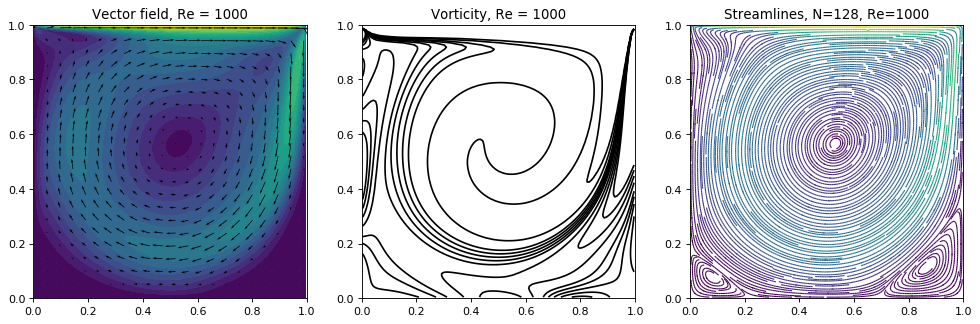

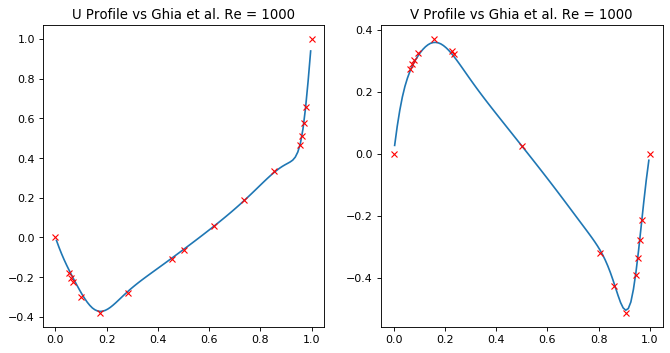

In [243]:
# Generate Plots

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import csv

# Compute properties
rho = rhoGPU.get().reshape(nY, nX)
u = uGPU.get().reshape(nY, nX) / uMax
v = vGPU.get().reshape(nY, nX) / uMax
dx = 1.0 / nX
dy = dx
(x,y) = np.meshgrid(np.linspace(0.5 * dx, 1.0 - 0.5 * dx, nX), np.linspace(0.5 * dy, (nY / nX) - 0.5 * dy, nY))
vmag = np.sqrt(u ** 2 + v ** 2)
vort = np.gradient(v, dx, edge_order=2, axis=1) - np.gradient(u, dy, edge_order=2, axis=0)

# Vector field
plt.figure(figsize=(15, 15), dpi = 80)
plt.subplot(1,3,1)
plt.contourf(x, y, vmag, 20)
quiverSkip = max(1, np.round(nX / 20).astype(np.int))
plt.quiver(x[::quiverSkip, ::quiverSkip],y[::quiverSkip, ::quiverSkip],u[::quiverSkip, ::quiverSkip],v[::quiverSkip, ::quiverSkip])
_ = plt.axis('scaled')
plt.xlim((0, 1))
plt.ylim((0,nY / nX))
plt.title('Vector field, Re = {Re}'.format(Re=reynoldsNumber))

# Vorticity contour lines
plt.subplot(1,3,2)
vortLevels = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 4, 5])
plt.contour(x, y, vort,litVortLevels,colors='k',linestyles='solid')
_ = plt.axis('scaled')
plt.xlim((0, 1))
plt.ylim((0,nY / nX))
plt.title('Vorticity, Re = {Re}'.format(Re=reynoldsNumber))

# Streamlines
ax0 = plt.subplot(1,3,3)
ax0.streamplot(x[0,:], y[:,0], u, v, density = 4, color = vmag, arrowstyle = '-', minlength = 0.1, linewidth = 1, transform = None)
plt.axis("scaled")
plt.title("Streamlines, N=%d, Re=%d" % (nX, reynoldsNumber))
plt.xlim((0, 1))
plt.ylim((0,nY / nX))

# Comparison to Ghia et al. results
litRe = [100,400,1000,3200,5000,7500,1000]
if reynoldsNumber in litRe and nX == nY:
    with open('ghiaV.csv', newline='') as csvfile:
        contents =  list(csv.reader(csvfile))
        
    labels = contents.pop(0)
    data = np.array(contents, dtype=np.float32)
    litV = {}
    for i,key in enumerate(labels):
        if i > 0:
            key = int(key)
        litV[key] = data[:,i]
    
    with open('ghiaU.csv', newline='') as csvfile:
        contents =  list(csv.reader(csvfile))
        
    labels = contents.pop(0)
    data = np.array(contents, dtype=np.float32)
    litU = {}
    for i,key in enumerate(labels):
        if i > 0:
            key = int(key)
        litU[key] = data[:,i]

    uInterpolator = RegularGridInterpolator((y[:,0], x[0,:]),u)
    profile = np.zeros((100,2))
    profile[:,0] = np.linspace(y[0,0], y[-1,-1], 100)
    profile[:,1] = np.ones(100) * 0.5
    uprof = uInterpolator(profile)
    plt.figure(figsize=(10,5), dpi= 80)
    plt.subplot(1,2,1)
    plt.plot(profile[:,0], uprof)
    plt.plot(litU['y'], litU[reynoldsNumber],'rx')
    plt.title('U Profile vs Ghia et al. Re = {Re}'.format(Re=reynoldsNumber))

    vInterpolator = RegularGridInterpolator((y[:,0], x[0,:]),v)
    profile = np.zeros((100,2))
    profile[:,0] = np.ones(100) * 0.5
    profile[:,1] = np.linspace(x[0,0], x[-1,-1], 100)
    vprof = vInterpolator(profile)
    plt.subplot(1,2,2)
    plt.plot(profile[:,1], vprof)
    plt.plot(litV['x'], litV[reynoldsNumber],'rx')
    plt.title('V Profile vs Ghia et al. Re = {Re}'.format(Re=reynoldsNumber))
